# Class Mapping 

|Label | prob | type|
|------|------|-----|
|0     | 0.0  | mono|
|1     | 0.333| mono|
|2     | 0.667| mono|
|3     | 1.0  | mono|
|4     | 0.0  | poly|
|5     | 0.333| poly|
|6     | 0.667| poly|
|7     | 1.0  | poly|

In [1]:
from utils.classifier import *
from utils.dataloader import *
from utils.features import *
from utils.helper import *
from utils.processing import *
import pickle

In [2]:
# Setting paths for data

RANDOM_STATE = 66
ROOT_PATH, DATA_PATH, OUT_PATH = get_paths()
PARAMS = []
print(ROOT_PATH)

/Users/moooooo16/Documents/Computer Vision/Project/elpv


In [3]:
from sklearn.model_selection import train_test_split

# Load data
img_path, prob, types, labels= load_data(DATA_PATH)

## Init feature extraction and split data
feature_builder = FeatureExtraction(DATA_PATH, img_path, labels)
X_train, X_test, y_train, y_test = feature_builder.split_data(train_test_split, randome_state=RANDOM_STATE, stratify=True, split_ratio=0.25)

[0 1 2 3 4 5 6 7] [588 117  56 313 920 178  50 402]


In [4]:
from sklearn.metrics import make_scorer, f1_score, balanced_accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans

# autoAug 
# Genearte more 
augment_funcs = [
    # flip_x,
    # flip_y,
    # rotate,
    # salt_pepper_noise,
]

# Preprocessing pipeline
preprocess_pipeline = [
    (strech_img, {
        }),
    # (clach_img, {
    #     'clipLimit': 2.0,
    #     'tileGridSize': (8, 8)}),
    # (guassian_blur, {
    #     'kernel_size': (0, 0),
    #     'sigmaX': 3}),
    # (lap_feature, {
    #     'dst': -1,
    #     'ksize' : 5}),
    # (morpo_opening, {
    #     'kernel': np.ones((2,2), np.uint8),
    #     'iterations': 1}),
    # (morph_smoothing, {
    # 'ses' : feature_builder.ses})
]


# K values for bag of words
K = [80, 160, 320, 640]

# sift buildrer parameters
sift_params = {
    'kmean_clf' : KMeans,
    'ks' : K,
    'state': RANDOM_STATE,
}

# Best SVM param
svm_param = {
    'C': 10,
    'kernel' : 'rbf',
    # 'gamma' : 0.0001,
    # 'class_weight' : 'balanced',
    # 'verbose' : False,
}

# Grid search param
grid_svm_params = {
    'estimator': SVC,
    'model_params': {
        'kernel': ['rbf', 'linear'],
        'C' : [0.1, 0.3, 0.5, 0.7, 1, 3, 5, 7 ,9, 10],
        'class_weight': ['balanced']},
    'scoring': {
        "F1_Weighted": make_scorer(f1_score, average='weighted'),
        "Balanced_Accuracy": make_scorer(balanced_accuracy_score),},
    'refit': 'F1_Weighted',
    'verbose' : 0
}

# SMOTE synthtic data parameter for up sampling
smote_params = {
    'grid_param': grid_svm_params,
    'knn' : KNeighborsClassifier,
    'n_neighbors': 5,
}

PARAMS.append(augment_funcs)
PARAMS.append(preprocess_pipeline)
PARAMS.append(sift_params)
# PARAMS.append(svm_param)
# PARAMS.append(grid_svm_params)
PARAMS.append(smote_params)

In [5]:
# Run pipeline for data augmentation
X_train_aug, y_train_aug = feature_builder.augmentation(X_train, y_train, augment_funcs=augment_funcs)

In [6]:
# run pipeline for data preprocessing

X_train_prepro = feature_builder.old_preprocess(X_train_aug, preprocess_pipeline = preprocess_pipeline)

X_test_prepro = feature_builder.old_preprocess(X_test, preprocess_pipeline = preprocess_pipeline)

print(X_train_prepro.shape, y_train_aug.shape)
print(X_test_prepro.shape, y_test.shape)

Pre-processing images:   0%|          | 0/1968 [00:00<?, ?it/s]

Pre-processing images: 100%|██████████| 656/656 [00:00<00:00, 4415.25it/s]

(1968, 300, 300) (1968,)
(656, 300, 300) (656,)


In [7]:
# Create sift descriptor for all images

train_kps, sift_train_des, empty_train_desc = feature_builder.get_sift_descriptor(X_train_prepro)
test_kps, sift_test_des, empty_test_desc = feature_builder.get_sift_descriptor(X_test_prepro)

Calculating descriptors: 100%|██████████| 656/656 [00:05<00:00, 130.27it/s]


In [8]:
# Find clusters for sift descriptor

# kmeans, sift_train_hist = feature_builder.build_sift_cluster(sift_train_des, **sift_params)

# with open(os.path.join(OUT_PATH, 'sift_kmeans'), 'wb') as f:
#     pickle.dump(kmeans, f)
# with open(os.path.join(OUT_PATH, 'sift_train_hist.pkl'), 'wb') as f:
#     pickle.dump(sift_train_hist, f)

Calculating kmeans for k = 80


Building histogram for k = 80: 100%|██████████| 1968/1968 [00:02<00:00, 771.99it/s]


Calculating kmeans for k = 160


Building histogram for k = 160: 100%|██████████| 1968/1968 [00:02<00:00, 730.45it/s]


Calculating kmeans for k = 320


Building histogram for k = 320: 100%|██████████| 1968/1968 [00:02<00:00, 678.92it/s]


Calculating kmeans for k = 640


Building histogram for k = 640: 100%|██████████| 1968/1968 [00:03<00:00, 594.43it/s]


In [9]:
# Load check point

kmeans, sift_train_hist = None, None
with open(os.path.join(OUT_PATH, 'sift_kmeans'), 'rb') as f:
    kmeans = pickle.load(f)
with open(os.path.join(OUT_PATH, 'sift_train_hist.pkl'), 'rb') as f:
    sift_train_hist = pickle.load(f)

In [10]:
# Build histogram for test data based on sift clusters

sift_test_hist = {}
for k in K:
    sift_test_hist[k] = feature_builder.get_hist(sift_test_des, kmeans[k], k)

Building histogram for k = 640: 100%|██████████| 656/656 [00:01<00:00, 556.65it/s]


----------------------------------------------------------------------------------------------------
Classification report for mono_svm
              precision    recall  f1-score   support

           0       0.70      0.93      0.80       147
           1       0.53      0.28      0.36        29
           2       0.00      0.00      0.00        14
           3       0.83      0.62      0.71        78

    accuracy                           0.72       268
   macro avg       0.52      0.46      0.47       268
weighted avg       0.68      0.72      0.68       268




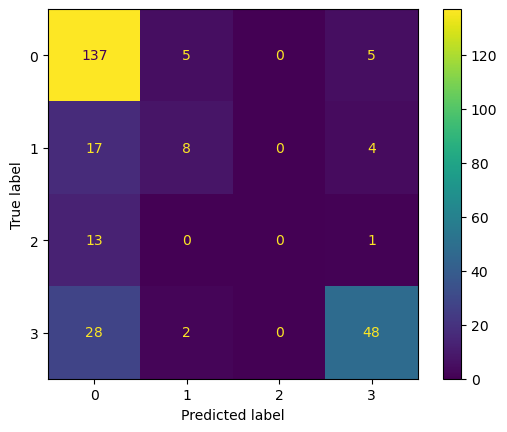


----------------------------------------------------------------------------------------------------
Classification report for poly_svm
              precision    recall  f1-score   support

           0       0.73      0.85      0.78       230
           1       0.42      0.29      0.34        45
           2       0.00      0.00      0.00        13
           3       0.60      0.52      0.56       100

    accuracy                           0.67       388
   macro avg       0.44      0.42      0.42       388
weighted avg       0.63      0.67      0.65       388




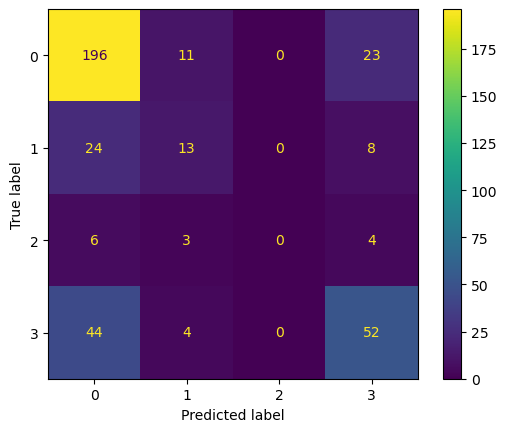


----------------------------------------------------------------------------------------------------
Classification report for combined_svm
              precision    recall  f1-score   support

           0       0.73      0.89      0.80       377
           1       0.50      0.26      0.34        74
           2       0.00      0.00      0.00        27
           3       0.70      0.61      0.65       178

    accuracy                           0.71       656
   macro avg       0.48      0.44      0.45       656
weighted avg       0.66      0.71      0.67       656




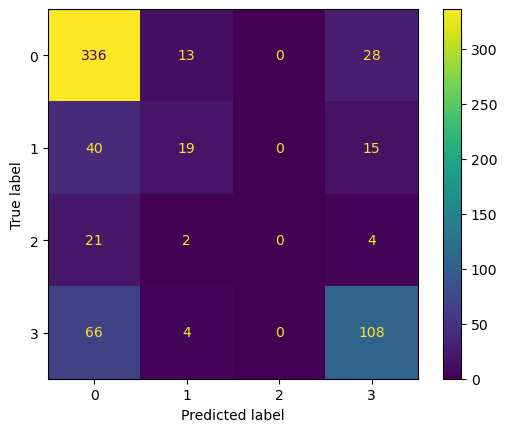


----------------------------------------------------------------------------------------------------
Classification report for mono_svm
              precision    recall  f1-score   support

           0       0.71      0.90      0.80       147
           1       0.47      0.31      0.38        29
           2       0.00      0.00      0.00        14
           3       0.87      0.69      0.77        78

    accuracy                           0.73       268
   macro avg       0.51      0.48      0.49       268
weighted avg       0.69      0.73      0.70       268




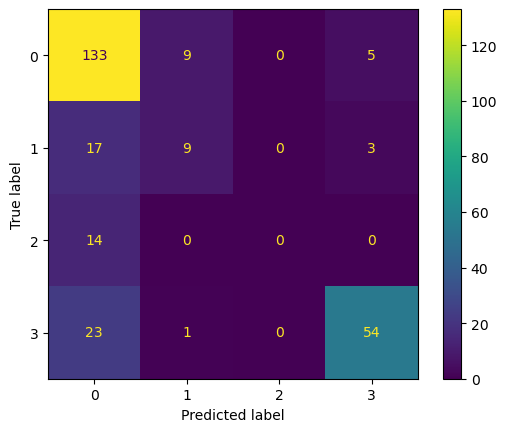


----------------------------------------------------------------------------------------------------
Classification report for poly_svm
              precision    recall  f1-score   support

           0       0.72      0.85      0.78       230
           1       0.32      0.16      0.21        45
           2       0.00      0.00      0.00        13
           3       0.60      0.58      0.59       100

    accuracy                           0.67       388
   macro avg       0.41      0.40      0.40       388
weighted avg       0.62      0.67      0.64       388




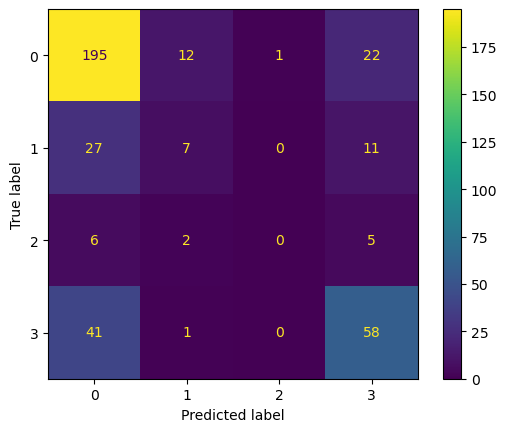


----------------------------------------------------------------------------------------------------
Classification report for combined_svm
              precision    recall  f1-score   support

           0       0.72      0.82      0.77       377
           1       0.39      0.20      0.27        74
           2       0.00      0.00      0.00        27
           3       0.63      0.65      0.64       178

    accuracy                           0.67       656
   macro avg       0.44      0.42      0.42       656
weighted avg       0.63      0.67      0.64       656




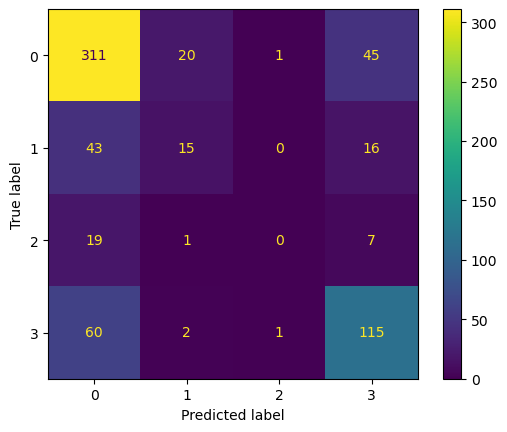


----------------------------------------------------------------------------------------------------
Classification report for mono_svm
              precision    recall  f1-score   support

           0       0.72      0.91      0.80       147
           1       0.57      0.28      0.37        29
           2       0.00      0.00      0.00        14
           3       0.82      0.69      0.75        78

    accuracy                           0.73       268
   macro avg       0.53      0.47      0.48       268
weighted avg       0.69      0.73      0.70       268




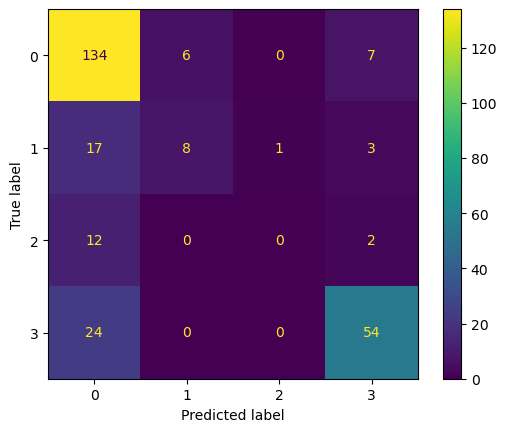


----------------------------------------------------------------------------------------------------
Classification report for poly_svm
              precision    recall  f1-score   support

           0       0.73      0.85      0.79       230
           1       0.45      0.22      0.30        45
           2       0.00      0.00      0.00        13
           3       0.57      0.57      0.57       100

    accuracy                           0.68       388
   macro avg       0.44      0.41      0.41       388
weighted avg       0.63      0.68      0.65       388




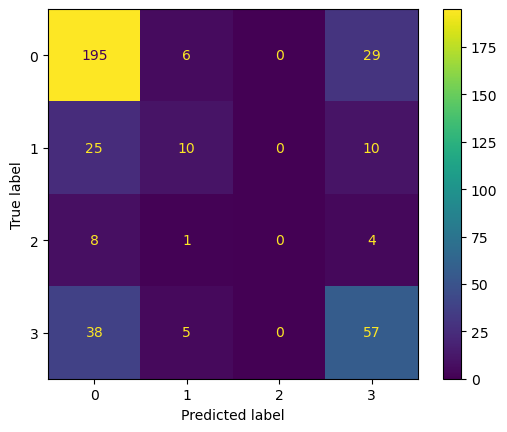


----------------------------------------------------------------------------------------------------
Classification report for combined_svm
              precision    recall  f1-score   support

           0       0.73      0.85      0.78       377
           1       0.45      0.23      0.30        74
           2       0.33      0.04      0.07        27
           3       0.64      0.62      0.63       178

    accuracy                           0.69       656
   macro avg       0.54      0.44      0.45       656
weighted avg       0.66      0.69      0.66       656




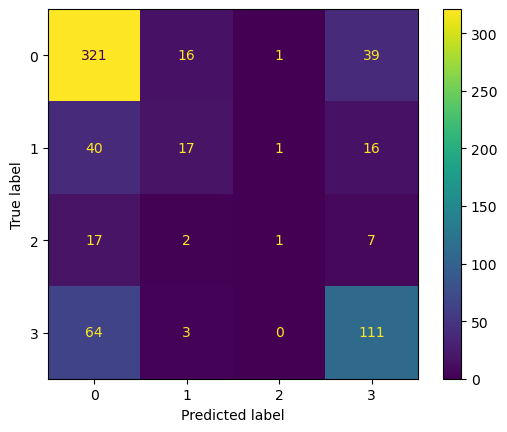


----------------------------------------------------------------------------------------------------
Classification report for mono_svm
              precision    recall  f1-score   support

           0       0.72      0.90      0.80       147
           1       0.42      0.28      0.33        29
           2       0.33      0.07      0.12        14
           3       0.89      0.71      0.79        78

    accuracy                           0.73       268
   macro avg       0.59      0.49      0.51       268
weighted avg       0.71      0.73      0.71       268




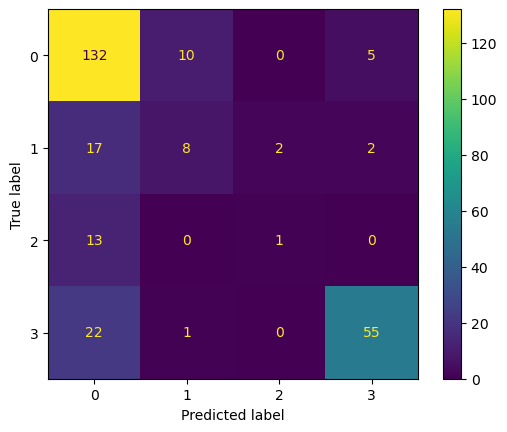


----------------------------------------------------------------------------------------------------
Classification report for poly_svm
              precision    recall  f1-score   support

           0       0.74      0.87      0.80       230
           1       0.55      0.24      0.34        45
           2       0.00      0.00      0.00        13
           3       0.58      0.57      0.57       100

    accuracy                           0.69       388
   macro avg       0.47      0.42      0.43       388
weighted avg       0.65      0.69      0.66       388




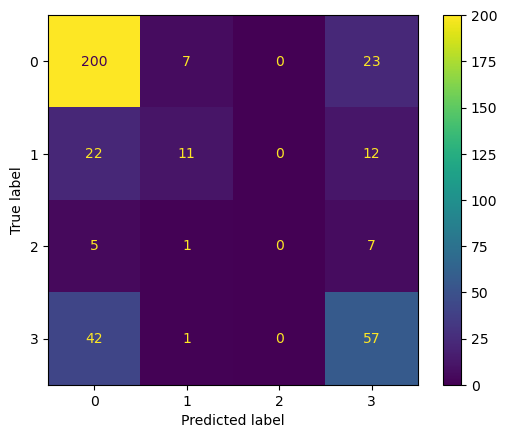


----------------------------------------------------------------------------------------------------
Classification report for combined_svm
              precision    recall  f1-score   support

           0       0.74      0.86      0.80       377
           1       0.41      0.23      0.30        74
           2       0.33      0.04      0.07        27
           3       0.66      0.63      0.65       178

    accuracy                           0.70       656
   macro avg       0.54      0.44      0.45       656
weighted avg       0.66      0.70      0.67       656




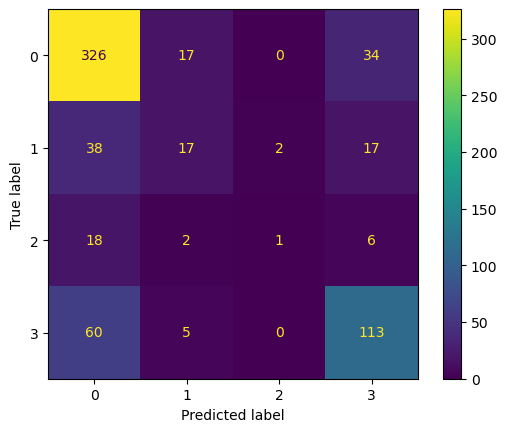

In [14]:
# Training and inferences

metrics = []
predictions = []
y_test_collection = []

# For each histogram for different K value
for X_train, X_test in zip(sift_train_hist.values(), sift_test_hist.values()):
    
    # Split data into mono, poly,  and combine
    mono_train_X, poly_train_X, mono_train_y, poly_train_y = mono_poly_split(X_train, y_train_aug)
    mono_test_X, poly_test_X, mono_test_y, poly_test_y = mono_poly_split(X_test, y_test)
    combine_train_X, combine_train_y = combine_mono_poly(mono_train_X, poly_train_X, mono_train_y, poly_train_y)
    combine_test_X, combine_test_y = combine_mono_poly(mono_test_X, poly_test_X, mono_test_y, poly_test_y)
    
    # Combine dataset for readability
    data_sets = {
    'mono_svm': (mono_train_X, mono_train_y, mono_test_X, mono_test_y),
    'poly_svm': (poly_train_X, poly_train_y, poly_test_X, poly_test_y),
    'combined_svm': (combine_train_X, combine_train_y, combine_test_X, combine_test_y)
    }
    accs = []
    f1s=[]
    
    # Train and inference
    for name in data_sets.keys():
        train_X, train_y, test_X, test_y = data_sets[name]
        
        svm = SVC(**svm_param).fit(train_X, train_y)
        
        prediction = svm.predict(test_X)
        acc, f1 = get_report(test_y, prediction, name)
        
        accs.append(acc)
        f1s.append(f1)
        predictions.append(prediction)
        
    y_test_collection.append(test_y)
    metrics.append((accs, f1s))


# Save metrics for further analysis
with open(os.path.join(OUT_PATH, 'sift_svm_metrics.pkl'), 'wb') as f:
    pickle.dump(metrics, f)

Class: [0 1 2 3] Val Score: 0.66 use {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}
----------------------------------------------------------------------------------------------------
Classification report for mono_svm
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       147
           1       0.26      0.38      0.31        29
           2       0.16      0.36      0.22        14
           3       0.74      0.67      0.70        78

    accuracy                           0.62       268
   macro avg       0.49      0.52      0.49       268
weighted avg       0.68      0.62      0.64       268




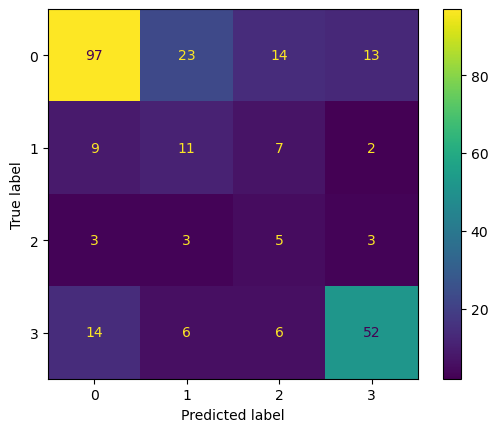


Class: [0 1 2 3] Val Score: 0.62 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for poly_svm
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       230
           1       0.43      0.42      0.43        45
           2       0.00      0.00      0.00        13
           3       0.53      0.60      0.56       100

    accuracy                           0.65       388
   macro avg       0.43      0.45      0.44       388
weighted avg       0.64      0.65      0.65       388




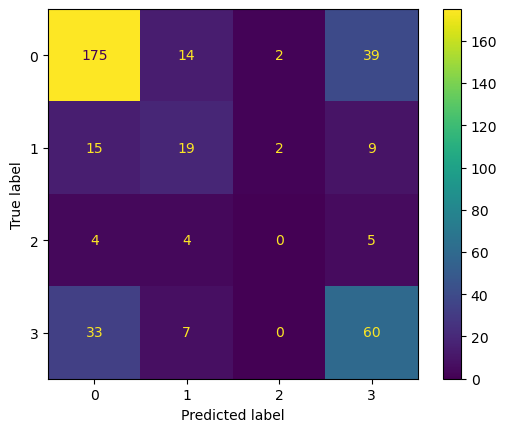


Class: [0 1 2 3] Val Score: 0.55 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for combined_svm
              precision    recall  f1-score   support

           0       0.80      0.66      0.72       377
           1       0.38      0.43      0.41        74
           2       0.12      0.41      0.18        27
           3       0.63      0.58      0.60       178

    accuracy                           0.60       656
   macro avg       0.48      0.52      0.48       656
weighted avg       0.68      0.60      0.63       656




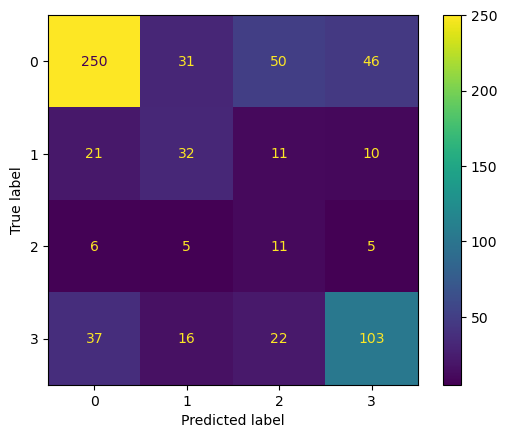


Class: [0 1 2 3] Val Score: 0.68 use {'C': 0.3, 'class_weight': 'balanced', 'kernel': 'linear'}
----------------------------------------------------------------------------------------------------
Classification report for mono_svm
              precision    recall  f1-score   support

           0       0.78      0.68      0.73       147
           1       0.27      0.48      0.35        29
           2       0.05      0.07      0.06        14
           3       0.79      0.69      0.74        78

    accuracy                           0.63       268
   macro avg       0.47      0.48      0.47       268
weighted avg       0.69      0.63      0.65       268




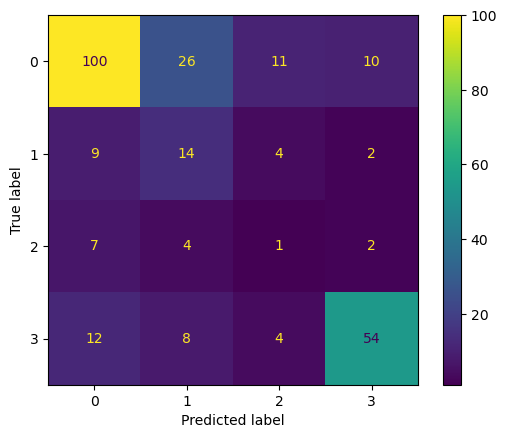


Class: [0 1 2 3] Val Score: 0.65 use {'C': 7, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for poly_svm
              precision    recall  f1-score   support

           0       0.75      0.76      0.76       230
           1       0.32      0.20      0.25        45
           2       0.00      0.00      0.00        13
           3       0.55      0.69      0.61       100

    accuracy                           0.65       388
   macro avg       0.41      0.41      0.40       388
weighted avg       0.62      0.65      0.63       388




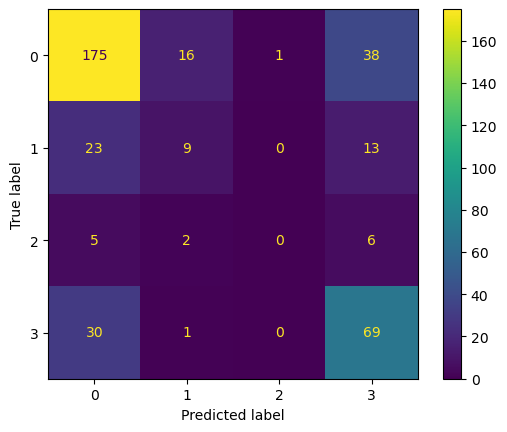


Class: [0 1 2 3] Val Score: 0.59 use {'C': 9, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for combined_svm
              precision    recall  f1-score   support

           0       0.77      0.68      0.72       377
           1       0.29      0.27      0.28        74
           2       0.17      0.37      0.23        27
           3       0.62      0.68      0.65       178

    accuracy                           0.62       656
   macro avg       0.46      0.50      0.47       656
weighted avg       0.65      0.62      0.63       656




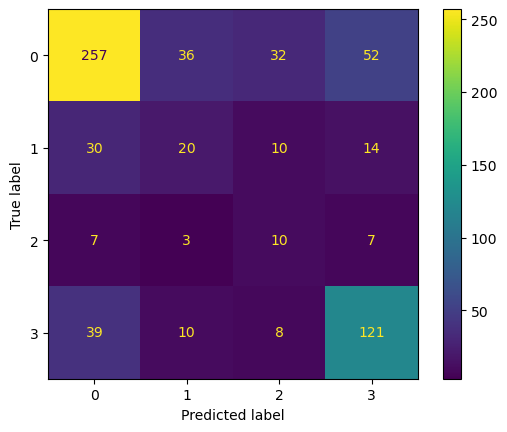


Class: [0 1 2 3] Val Score: 0.68 use {'C': 9, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for mono_svm
              precision    recall  f1-score   support

           0       0.78      0.75      0.76       147
           1       0.33      0.41      0.37        29
           2       0.07      0.14      0.10        14
           3       0.83      0.68      0.75        78

    accuracy                           0.66       268
   macro avg       0.50      0.50      0.49       268
weighted avg       0.71      0.66      0.68       268




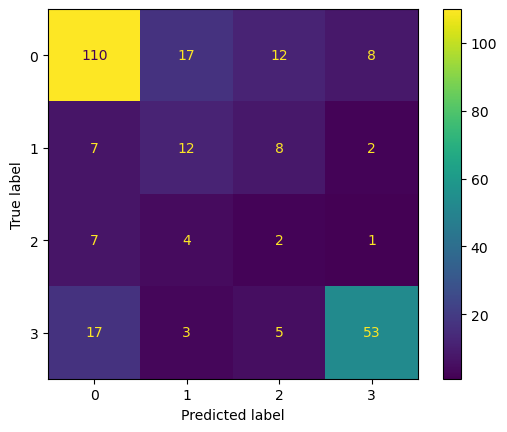


Class: [0 1 2 3] Val Score: 0.66 use {'C': 7, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for poly_svm
              precision    recall  f1-score   support

           0       0.75      0.82      0.78       230
           1       0.43      0.22      0.29        45
           2       0.00      0.00      0.00        13
           3       0.55      0.62      0.58       100

    accuracy                           0.67       388
   macro avg       0.43      0.42      0.42       388
weighted avg       0.64      0.67      0.65       388




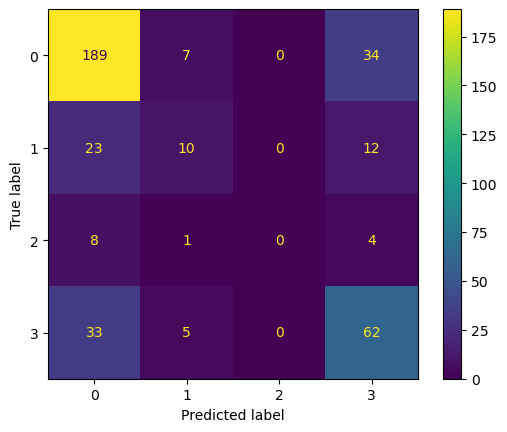


Class: [0 1 2 3] Val Score: 0.60 use {'C': 7, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for combined_svm
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       377
           1       0.33      0.30      0.31        74
           2       0.14      0.22      0.17        27
           3       0.61      0.65      0.63       178

    accuracy                           0.64       656
   macro avg       0.46      0.47      0.47       656
weighted avg       0.65      0.64      0.64       656




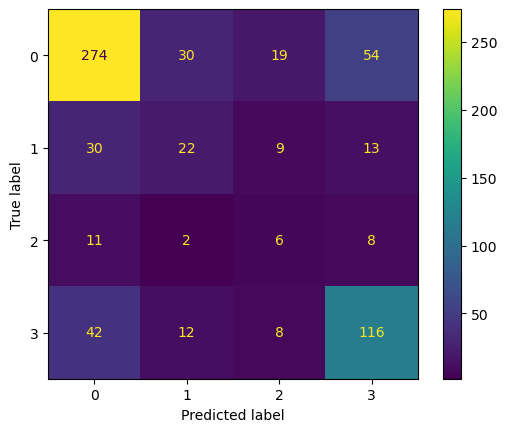


Class: [0 1 2 3] Val Score: 0.70 use {'C': 7, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for mono_svm
              precision    recall  f1-score   support

           0       0.82      0.77      0.80       147
           1       0.39      0.59      0.47        29
           2       0.26      0.36      0.30        14
           3       0.85      0.74      0.79        78

    accuracy                           0.72       268
   macro avg       0.58      0.61      0.59       268
weighted avg       0.76      0.72      0.73       268




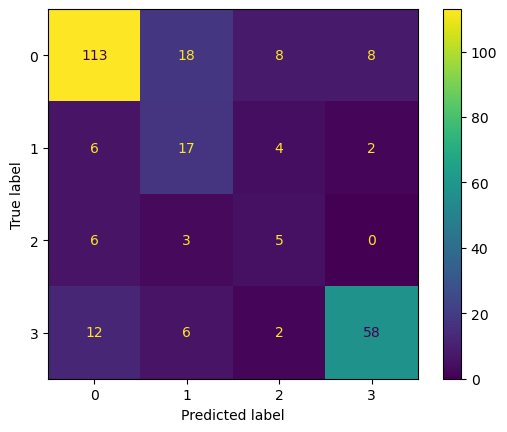


Class: [0 1 2 3] Val Score: 0.66 use {'C': 5, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for poly_svm
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       230
           1       0.57      0.27      0.36        45
           2       0.00      0.00      0.00        13
           3       0.56      0.61      0.58       100

    accuracy                           0.69       388
   macro avg       0.47      0.43      0.43       388
weighted avg       0.65      0.69      0.66       388




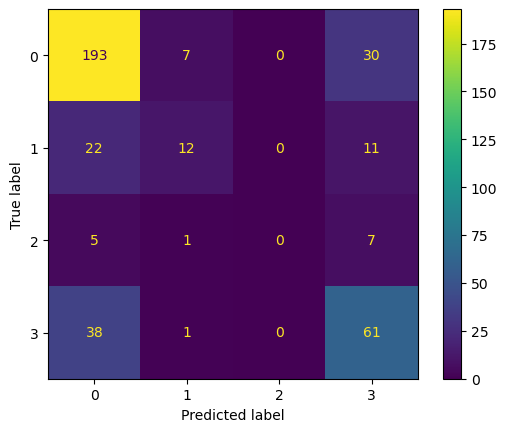


Class: [0 1 2 3] Val Score: 0.62 use {'C': 9, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for combined_svm
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       377
           1       0.44      0.34      0.38        74
           2       0.26      0.19      0.22        27
           3       0.67      0.65      0.66       178

    accuracy                           0.70       656
   macro avg       0.54      0.50      0.51       656
weighted avg       0.68      0.70      0.69       656




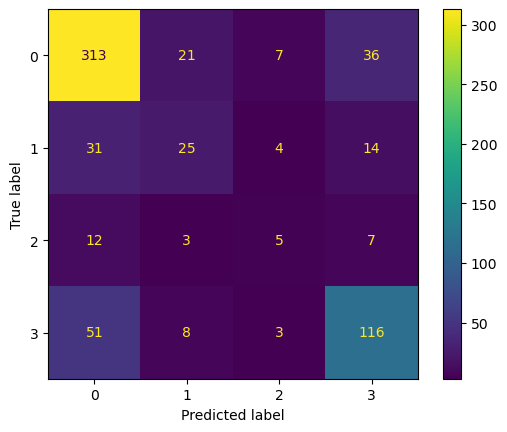

In [12]:
# Same strucutr, but use grid seach to find best hyperparameters


grid_metrics = []

for X_train, X_test in zip(sift_train_hist.values(), sift_test_hist.values()):
    mono_train_X, poly_train_X, mono_train_y, poly_train_y = mono_poly_split(X_train, y_train_aug)
    mono_test_X, poly_test_X, mono_test_y, poly_test_y = mono_poly_split(X_test, y_test)
    combine_train_X, combine_train_y = combine_mono_poly(mono_train_X, poly_train_X, mono_train_y, poly_train_y)
    combine_test_X, combine_test_y = combine_mono_poly(mono_test_X, poly_test_X, mono_test_y, poly_test_y)
    
    data_sets = {
    'mono_svm': (mono_train_X, mono_train_y, mono_test_X, mono_test_y),
    'poly_svm': (poly_train_X, poly_train_y, poly_test_X, poly_test_y),
    'combined_svm': (combine_train_X, combine_train_y, combine_test_X, combine_test_y)
    }
    accs = []
    f1s=[]
    for name in data_sets.keys():
        train_X, train_y, test_X, test_y = data_sets[name]
        result, best_clf  = grid_search(train_X, train_y, **grid_svm_params)
        grid_pred = best_clf.predict(test_X)
        acc, f1 = get_report(test_y, grid_pred, name)
        accs.append(acc)
        f1s.append(f1)
    
    metrics.append((accs, f1s))
    
with open(os.path.join(OUT_PATH, 'sift_grid_metrics.pkl'), 'wb') as f:
    pickle.dump(grid_metrics, f)

Trainig on: (array([-1,  0]), array([365, 441]))
Class: [-1  0] Val Score: 0.77 use {'C': 9, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 704 synthetic samples.
Trainig on: (array([-1.,  1.]), array([718, 792]))
Class: [-1.  1.] Val Score: 0.86 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 756 synthetic samples.
Trainig on: (array([-1.,  2.]), array([764, 798]))
Class: [-1.  2.] Val Score: 0.90 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 470 synthetic samples.
Trainig on: (array([-1.,  3.]), array([571, 705]))
Class: [-1.  3.] Val Score: 0.84 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for mono_svm
              precision    recall  f1-score   support

           0       0.81      0.76      0.79       147
           1       0.39      0.45      0.42        29
           2       0.19      0.29  

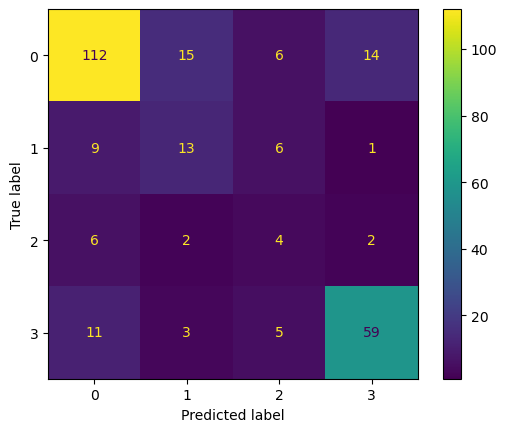


Trainig on: (array([-1,  0]), array([472, 690]))
Class: [-1  0] Val Score: 0.72 use {'C': 5, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 931 synthetic samples.
Trainig on: (array([-1.,  1.]), array([1029, 1064]))
Class: [-1.  1.] Val Score: 0.94 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1110 synthetic samples.
Trainig on: (array([-1.,  2.]), array([1125, 1147]))
Class: [-1.  2.] Val Score: 0.98 use {'C': 9, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 604 synthetic samples.
Trainig on: (array([-1.,  3.]), array([860, 906]))
Class: [-1.  3.] Val Score: 0.89 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for poly_svm
              precision    recall  f1-score   support

           0       0.75      0.79      0.77       230
           1       0.40      0.36      0.38        45
           2       0.00      0

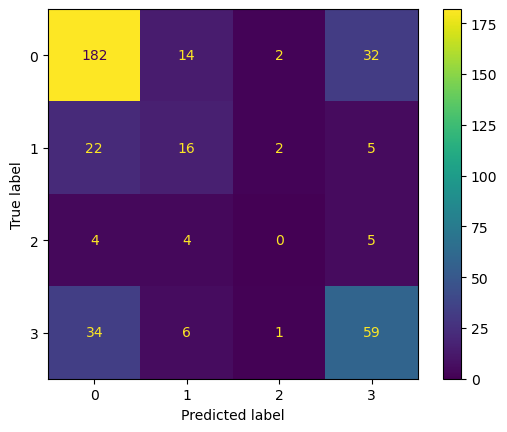


Trainig on: (array([-1,  0]), array([ 837, 1131]))
Class: [-1  0] Val Score: 0.64 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1547 synthetic samples.
Trainig on: (array([-1.,  1.]), array([1747, 1768]))
Class: [-1.  1.] Val Score: 0.86 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1817 synthetic samples.
Trainig on: (array([-1.,  2.]), array([1889, 1896]))
Class: [-1.  2.] Val Score: 0.91 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1074 synthetic samples.
Trainig on: (array([-1.,  3.]), array([1431, 1611]))
Class: [-1.  3.] Val Score: 0.77 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for combined_svm
              precision    recall  f1-score   support

           0       0.77      0.75      0.76       377
           1       0.41      0.38      0.39        74
           2      

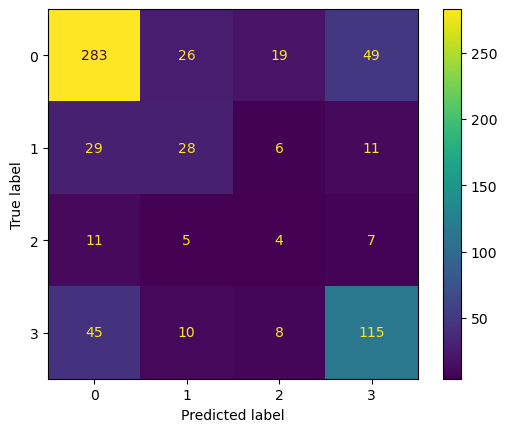


Trainig on: (array([-1,  0]), array([365, 441]))
Class: [-1  0] Val Score: 0.79 use {'C': 0.1, 'class_weight': 'balanced', 'kernel': 'linear'}
Generated 704 synthetic samples.
Trainig on: (array([-1.,  1.]), array([718, 792]))
Class: [-1.  1.] Val Score: 0.86 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 756 synthetic samples.
Trainig on: (array([-1.,  2.]), array([764, 798]))
Class: [-1.  2.] Val Score: 0.93 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 470 synthetic samples.
Trainig on: (array([-1.,  3.]), array([571, 705]))
Class: [-1.  3.] Val Score: 0.83 use {'C': 9, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for mono_svm
              precision    recall  f1-score   support

           0       0.79      0.78      0.79       147
           1       0.35      0.38      0.37        29
           2       0.23      0

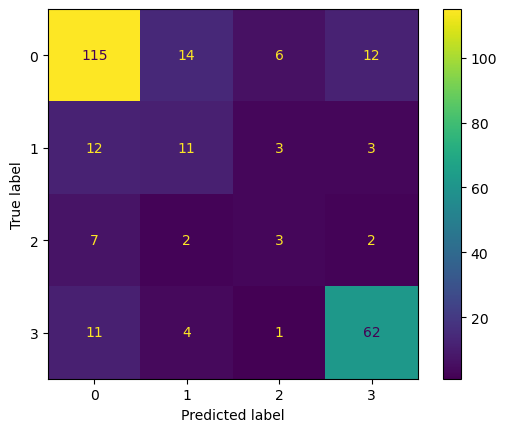


Trainig on: (array([-1,  0]), array([472, 690]))
Class: [-1  0] Val Score: 0.71 use {'C': 3, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 931 synthetic samples.
Trainig on: (array([-1.,  1.]), array([1029, 1064]))
Class: [-1.  1.] Val Score: 0.97 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1110 synthetic samples.
Trainig on: (array([-1.,  2.]), array([1125, 1147]))
Class: [-1.  2.] Val Score: 0.99 use {'C': 9, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 604 synthetic samples.
Trainig on: (array([-1.,  3.]), array([860, 906]))
Class: [-1.  3.] Val Score: 0.87 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for poly_svm
              precision    recall  f1-score   support

           0       0.75      0.81      0.78       230
           1       0.38      0.18      0.24        45
           2       0.11      0

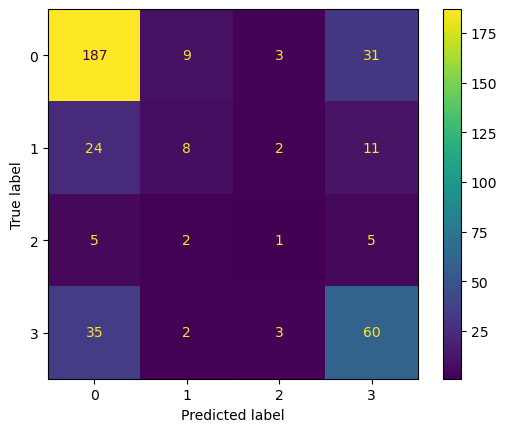


Trainig on: (array([-1,  0]), array([ 837, 1131]))
Class: [-1  0] Val Score: 0.67 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1547 synthetic samples.
Trainig on: (array([-1.,  1.]), array([1747, 1768]))
Class: [-1.  1.] Val Score: 0.88 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1817 synthetic samples.
Trainig on: (array([-1.,  2.]), array([1889, 1896]))
Class: [-1.  2.] Val Score: 0.94 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1074 synthetic samples.
Trainig on: (array([-1.,  3.]), array([1431, 1611]))
Class: [-1.  3.] Val Score: 0.78 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for combined_svm
              precision    recall  f1-score   support

           0       0.75      0.76      0.75       377
           1       0.36      0.27      0.31        74
           2      

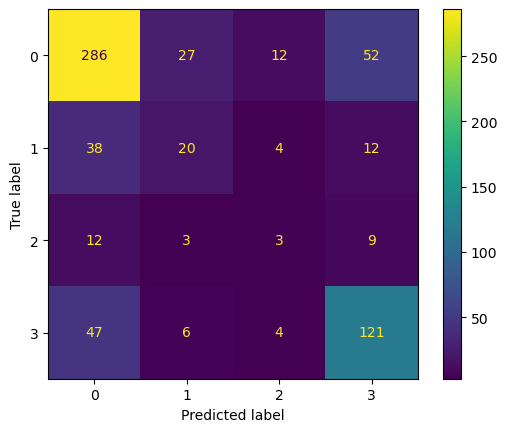


Trainig on: (array([-1,  0]), array([365, 441]))
Class: [-1  0] Val Score: 0.77 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 704 synthetic samples.
Trainig on: (array([-1.,  1.]), array([718, 792]))
Class: [-1.  1.] Val Score: 0.89 use {'C': 9, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 756 synthetic samples.
Trainig on: (array([-1.,  2.]), array([764, 798]))
Class: [-1.  2.] Val Score: 0.94 use {'C': 9, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 470 synthetic samples.
Trainig on: (array([-1.,  3.]), array([571, 705]))
Class: [-1.  3.] Val Score: 0.84 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for mono_svm
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       147
           1       0.30      0.24      0.27        29
           2       0.12      0.07  

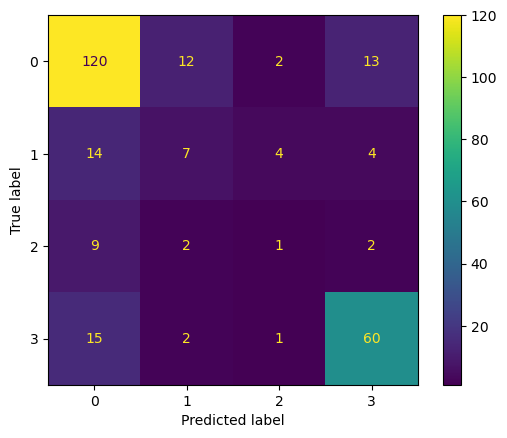


Trainig on: (array([-1,  0]), array([472, 690]))
Class: [-1  0] Val Score: 0.72 use {'C': 5, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 931 synthetic samples.
Trainig on: (array([-1.,  1.]), array([1029, 1064]))
Class: [-1.  1.] Val Score: 0.95 use {'C': 7, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1110 synthetic samples.
Trainig on: (array([-1.,  2.]), array([1125, 1147]))
Class: [-1.  2.] Val Score: 0.99 use {'C': 7, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 604 synthetic samples.
Trainig on: (array([-1.,  3.]), array([860, 906]))
Class: [-1.  3.] Val Score: 0.81 use {'C': 9, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for poly_svm
              precision    recall  f1-score   support

           0       0.72      0.81      0.76       230
           1       0.33      0.13      0.19        45
           2       0.00      0.0

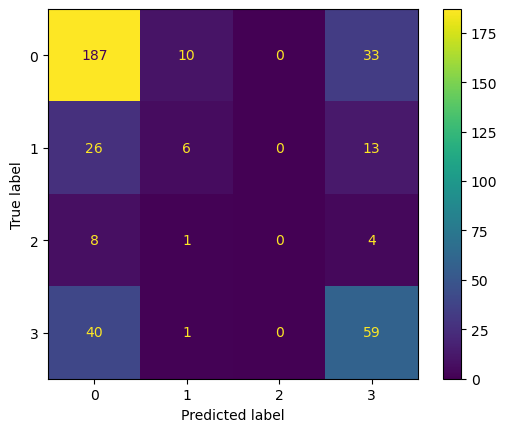


Trainig on: (array([-1,  0]), array([ 837, 1131]))
Class: [-1  0] Val Score: 0.67 use {'C': 3, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1547 synthetic samples.
Trainig on: (array([-1.,  1.]), array([1747, 1768]))
Class: [-1.  1.] Val Score: 0.89 use {'C': 9, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1817 synthetic samples.
Trainig on: (array([-1.,  2.]), array([1889, 1896]))
Class: [-1.  2.] Val Score: 0.95 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1074 synthetic samples.
Trainig on: (array([-1.,  3.]), array([1431, 1611]))
Class: [-1.  3.] Val Score: 0.77 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for combined_svm
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       377
           1       0.38      0.24      0.30        74
           2       0

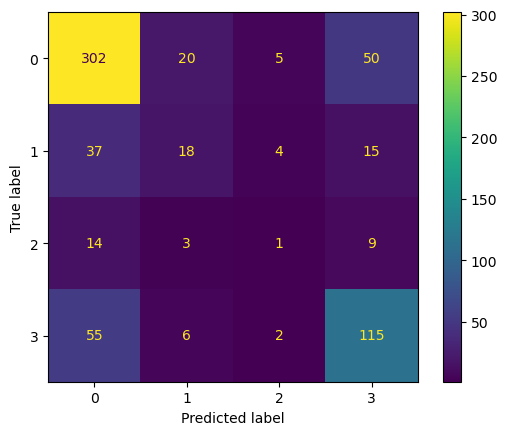


Trainig on: (array([-1,  0]), array([365, 441]))
Class: [-1  0] Val Score: 0.77 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 704 synthetic samples.
Trainig on: (array([-1.,  1.]), array([718, 792]))
Class: [-1.  1.] Val Score: 0.89 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 756 synthetic samples.
Trainig on: (array([-1.,  2.]), array([764, 798]))
Class: [-1.  2.] Val Score: 0.94 use {'C': 9, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 470 synthetic samples.
Trainig on: (array([-1.,  3.]), array([571, 705]))
Class: [-1.  3.] Val Score: 0.84 use {'C': 7, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for mono_svm
              precision    recall  f1-score   support

           0       0.76      0.80      0.78       147
           1       0.35      0.38      0.37        29
           2       0.12      0.07  

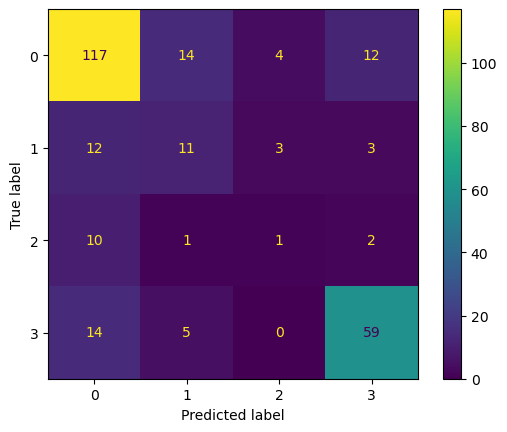


Trainig on: (array([-1,  0]), array([472, 690]))
Class: [-1  0] Val Score: 0.74 use {'C': 3, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 931 synthetic samples.
Trainig on: (array([-1.,  1.]), array([1029, 1064]))
Class: [-1.  1.] Val Score: 0.93 use {'C': 7, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1110 synthetic samples.
Trainig on: (array([-1.,  2.]), array([1125, 1147]))
Class: [-1.  2.] Val Score: 0.97 use {'C': 5, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 604 synthetic samples.
Trainig on: (array([-1.,  3.]), array([860, 906]))
Class: [-1.  3.] Val Score: 0.78 use {'C': 7, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for poly_svm
              precision    recall  f1-score   support

           0       0.73      0.85      0.79       230
           1       0.50      0.22      0.31        45
           2       0.00      0.0

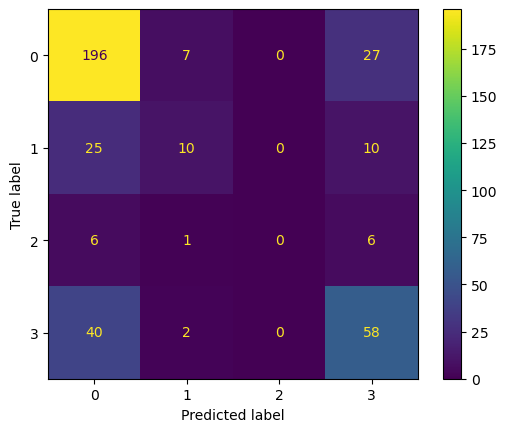


Trainig on: (array([-1,  0]), array([ 837, 1131]))
Class: [-1  0] Val Score: 0.69 use {'C': 5, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1547 synthetic samples.
Trainig on: (array([-1.,  1.]), array([1747, 1768]))
Class: [-1.  1.] Val Score: 0.89 use {'C': 3, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1817 synthetic samples.
Trainig on: (array([-1.,  2.]), array([1889, 1896]))
Class: [-1.  2.] Val Score: 0.95 use {'C': 9, 'class_weight': 'balanced', 'kernel': 'rbf'}
Generated 1074 synthetic samples.
Trainig on: (array([-1.,  3.]), array([1431, 1611]))
Class: [-1.  3.] Val Score: 0.76 use {'C': 10, 'class_weight': 'balanced', 'kernel': 'rbf'}
----------------------------------------------------------------------------------------------------
Classification report for combined_svm
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       377
           1       0.41      0.30      0.34        74
           2       0.

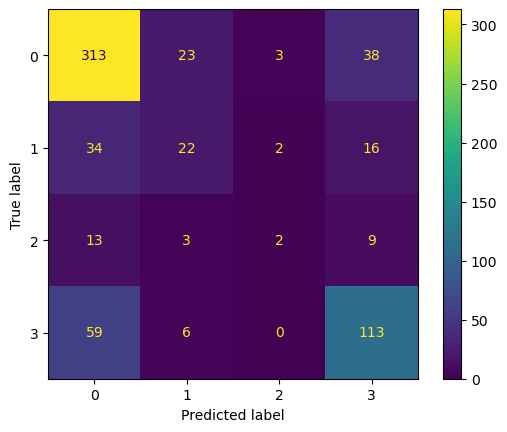

In [13]:
# Same structure but use SMOTE to up sample data, this uses ovr strategy
# Ovo terns out to be worse than ovr, so here we only keep ovr

ovr_metrics = []

for X_train, X_test in zip(sift_train_hist.values(), sift_test_hist.values()):
    mono_train_X, poly_train_X, mono_train_y, poly_train_y = mono_poly_split(X_train, y_train_aug)
    mono_test_X, poly_test_X, mono_test_y, poly_test_y = mono_poly_split(X_test, y_test)
    combine_train_X, combine_train_y = combine_mono_poly(mono_train_X, poly_train_X, mono_train_y, poly_train_y)
    combine_test_X, combine_test_y = combine_mono_poly(mono_test_X, poly_test_X, mono_test_y, poly_test_y)
    
    data_sets = {
    'mono_svm': (mono_train_X, mono_train_y, mono_test_X, mono_test_y),
    'poly_svm': (poly_train_X, poly_train_y, poly_test_X, poly_test_y),
    'combined_svm': (combine_train_X, combine_train_y, combine_test_X, combine_test_y)
    }
    accs = []
    f1s=[]
    for name in data_sets.keys():
        train_X, train_y, test_X, test_y = data_sets[name]
        smote_results, smote_clfs = one_vs_other_up_sampling(train_X, train_y, total_classes=np.unique(train_y), **smote_params)
        smote_distance, smote_preds = distance_vote(test_X, smote_clfs)
        acc, f1 = get_report(test_y, smote_preds, name)
        
        accs.append(acc)
        f1s.append(f1)
    
    metrics.append((accs, f1s))
    
with open(os.path.join(OUT_PATH, 'sift_ovr_metrics.pkl'), 'wb') as f:
    pickle.dump(ovr_metrics, f)